Use dropout to activate different neurons

If faulty neuron is dropped, fault has no effect.
- this could be useful in training and inference

TODO
- try training 2 models.
  - 1 with injected faults but no dropout
  - 1 with injected faults with dropout at injection layer

- see effect of data volume on faults
  - try training same model with same number of faults several times.
  - each time use a different number of epochs
  - train 10 times for each number of epochs
  
  - each time use same number of epochs but different number of samples
  - train 10 times for each number of samples

  

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import error_inject_layer
import dense_error_injection
import error_inject_optimizer
from tensorflow.python.util import deprecation
print(tf.__version__)

2.4.1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### Load Data

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Preprocess Data

In [5]:
# Scale values
train_images = train_images / 255.0
test_images = test_images / 255.0

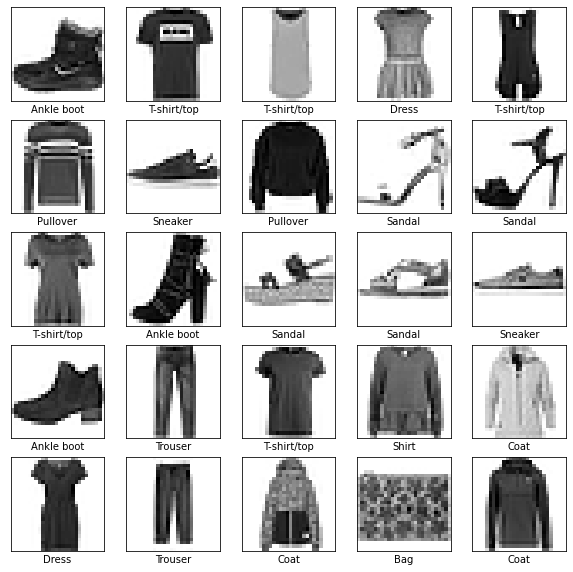

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Simple Error Free Model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
train_history = model.fit(train_images, train_labels, epochs=300, verbose=0, validation_data=(test_images,  test_labels))

In [10]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 1.5063 - accuracy: 0.8862

Test accuracy: 0.8862000107765198


In [11]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [12]:
predictions = probability_model.predict(test_images)

## Define function for training with error

In [8]:

def loss(model, loss_object, x, y):
  # print("call")
  y_hat = model(x, training=True)
  # print("Y:")
  # print(y)
  # print("Y_HAT:")
  # print(y_hat)

  return loss_object(y_true=y, y_pred=y_hat)

def grad(model, loss_object, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, loss_object, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

def train_step(model, optimizer, loss_object, x, y):
  # Optimize the model
  loss_value, grads = grad(model, loss_object, x, y)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  return loss_value
    
    
def train(model, optimizer, loss_object, inputs, epochs=50):
  train_loss_results = []
  train_accuracy_results = []

  for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    # Training loop - using batches of 32
    for x, y in inputs:
      loss = train_step(model, optimizer, loss_object, x, y)
      epoch_loss_avg(loss)
      epoch_accuracy(y, model(x))
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 100 == 0:

      print("RESULTS")
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
      
  train_history = (train_loss_results, train_accuracy_results)
  return train_history



In [11]:
train_images[0:100,:,:].shape

(100, 28, 28)

### Model with 0.1 error rate in hidden layer, error_peristance = False

In [14]:
error_model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(28, 28)),
              dense_error_injection.Dense_Error_Injection(128, activation=tf.nn.relu,
                                                          error_rate=0.001, 
                                                          error_type='random_bit_flip_percentage',
                                                          error_inject_phase='training',
                                                          error_element='weight',
                                                          verbose=0,
                                                          error_persistence=False
                                                          ),
              tf.keras.layers.Dense(10)
])

In [15]:
error_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
# error_train_history = error_model.fit(train_images, train_labels, epochs=100, verbose=0, validation_data=(test_images,  test_labels))

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
error_train_history = train(error_model, optimizer, loss_object, train_dataset, epochs=300)

RESULTS
Epoch 000: Loss: 0.503, Accuracy: 83.173%
RESULTS
Epoch 100: Loss: 12879198171430912.000, Accuracy: 94.392%
RESULTS
Epoch 200: Loss: nan, Accuracy: 10.000%


In [17]:
test_loss, test_acc = error_model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: nan - accuracy: 0.1000

Test accuracy: 0.10000000149011612


### Model with 0.1 error rate in hidden layer, error_peristance = True

In [18]:
error_model_2 = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(28, 28)),
              dense_error_injection.Dense_Error_Injection(128, activation=tf.nn.relu,
                                                          error_rate=0.001, 
                                                          error_type='random_bit_flip_percentage',
                                                          error_inject_phase='training',
                                                          error_element='weight',
                                                          verbose=0,
                                                          error_persistence=True
                                                          ),
              tf.keras.layers.Dense(10)
])

In [19]:
error_model_2.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
# error_train_history = error_model.fit(train_images, train_labels, epochs=100, verbose=0, validation_data=(test_images,  test_labels))

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
error_train_history_2 = train(error_model_2, optimizer, loss_object, train_dataset, epochs=300)

RESULTS
Epoch 000: Loss: 0.511, Accuracy: 82.748%
RESULTS
Epoch 100: Loss: nan, Accuracy: 10.000%
RESULTS
Epoch 200: Loss: nan, Accuracy: 10.000%


In [21]:
test_loss, test_acc = error_model_2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: nan - accuracy: 0.1000

Test accuracy: 0.10000000149011612


### Testing multiple dropout rates during training

TODO also try with error_persistence=False

In [12]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

error_rate = 0.005

# error_rates = [0.0, 0.0001, 0.001, 0.01,
#                0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
#                0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
error_rate_train_history = []
sample_size = 20000


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images[0:sample_size,:,:], train_labels[0:sample_size])).batch(32)
for dropout_rate in dropout_rates:
    print(f'Error rate: {error_rate}')
    test_model = tf.keras.Sequential([
                 tf.keras.layers.Flatten(input_shape=(28, 28)),
                 tf.keras.layers.Dense(512),
                 dense_error_injection.Dense_Error_Injection(512, activation=tf.nn.relu,
                                                             error_rate=error_rate, 
                                                             error_type='random_bit_flip_percentage',
                                                             error_inject_phase='training',
                                                             error_element='weight',
                                                             verbose=0,
                                                             error_persistence=True
                                                             ),
                 tf.keras.layers.Dropout(dropout_rate),
                 tf.keras.layers.Dense(10)
    ])
    
    test_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    
    num_epochs = 300
    error_train_history_tmp = train(test_model, optimizer, loss_object, train_dataset, epochs=num_epochs)

    
#     train_history_tmp = test_model.fit(x=train_images, y=train_labels, epochs=num_epochs,
#                                        validation_data=(test_images,  test_labels),
#                                        batch_size=32, verbose=0)
    
    error_rate_train_history.append(error_train_history_tmp)


Error rate: 0.005
RESULTS
Epoch 000: Loss: 0.707, Accuracy: 80.075%
RESULTS
Epoch 100: Loss: 1720054144.000, Accuracy: 83.335%
RESULTS
Epoch 200: Loss: 612445184.000, Accuracy: 83.805%
Error rate: 0.005
RESULTS
Epoch 000: Loss: 1.574, Accuracy: 80.020%
RESULTS
Epoch 100: Loss: 1086696832.000, Accuracy: 83.030%
RESULTS
Epoch 200: Loss: 1078953728.000, Accuracy: 80.825%
Error rate: 0.005
RESULTS
Epoch 000: Loss: 0.942, Accuracy: 79.070%
RESULTS
Epoch 100: Loss: 1937027584.000, Accuracy: 82.155%
RESULTS
Epoch 200: Loss: 953794368.000, Accuracy: 80.695%
Error rate: 0.005
RESULTS
Epoch 000: Loss: 0.780, Accuracy: 79.130%
RESULTS
Epoch 100: Loss: 1676230144.000, Accuracy: 81.680%
RESULTS
Epoch 200: Loss: 1495085056.000, Accuracy: 79.265%


KeyboardInterrupt: 

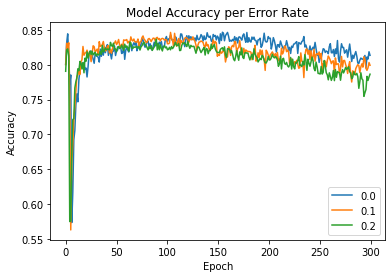

<Figure size 432x432 with 0 Axes>

In [19]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][1])
plt.plot(error_rate_train_history[1][1])
plt.plot(error_rate_train_history[2][1])
# plt.plot(error_rate_train_history[3][1])
# plt.plot(error_rate_train_history[4][1])
# plt.plot(error_rate_train_history[5][1])
# plt.plot(error_rate_train_history[6][1])
# plt.plot(error_rate_train_history[5][1])
plt.title('Model Accuracy per Error Rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['0.0', '0.1', '0.2', '0.3', '0.4'])
plt.figure(figsize=(6, 6))
plt.show()

In [ ]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][0])
plt.plot(error_rate_train_history[1][0])
plt.plot(error_rate_train_history[2][0])
plt.plot(error_rate_train_history[3][0])
plt.plot(error_rate_train_history[4][0])
# plt.plot(error_rate_train_history[5][1])
plt.title('Model Loss per Error Rate')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(top=0.6, bottom=0)
plt.legend([
            f'0.0 error rate',
            f'0.0001 error rate',
            f'0.001 error rate',
            f'0.01 error rate',
            f'0.1 error rate',
            f'0.5 error rate'
            ])
plt.figure(figsize=(6, 6))
# plt.show()
plt.savefig('figures/error_model_loss', bbox_inches='tight')

# Same dropout rates as above, but now with error persistence = False

In [ ]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

error_rate = 0.005

# error_rates = [0.0, 0.0001, 0.001, 0.01,
#                0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
#                0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
error_rate_train_history = []


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images[0:sample_size,:,:], train_labels[0:sample_size])).batch(32)
for dropout_rate in dropout_rates:
    print(f'Error rate: {error_rate}')
    test_model = tf.keras.Sequential([
                 tf.keras.layers.Flatten(input_shape=(28, 28)),
                 tf.keras.layers.Dense(512),
                 dense_error_injection.Dense_Error_Injection(512, activation=tf.nn.relu,
                                                             error_rate=error_rate, 
                                                             error_type='random_bit_flip_percentage',
                                                             error_inject_phase='training',
                                                             error_element='weight',
                                                             verbose=0,
                                                             error_persistence=False
                                                             ),
                 tf.keras.layers.Dropout(dropout_rate),
                 tf.keras.layers.Dense(10)
    ])
    
    test_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    
    num_epochs = 300
    error_train_history_tmp = train(test_model, optimizer, loss_object, train_dataset, epochs=num_epochs)

    
#     train_history_tmp = test_model.fit(x=train_images, y=train_labels, epochs=num_epochs,
#                                        validation_data=(test_images,  test_labels),
#                                        batch_size=32, verbose=0)
    
    error_rate_train_history.append(error_train_history_tmp)


In [ ]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][1])
plt.plot(error_rate_train_history[1][1])
plt.plot(error_rate_train_history[2][1])
plt.plot(error_rate_train_history[3][1])
plt.plot(error_rate_train_history[4][1])
plt.plot(error_rate_train_history[5][1])
plt.plot(error_rate_train_history[6][1])
# plt.plot(error_rate_train_history[5][1])
plt.title('Model Accuracy per Error Rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'])
plt.figure(figsize=(6, 6))
plt.show()

In [38]:
np.save('results/error_rate_train_history', error_rate_train_history, allow_pickle=True, fix_imports=True)

In [ ]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][1].history['accuracy'])
plt.plot(error_rate_train_history[1][1].history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([
            f'{error_rate_train_history[0][0]} error rate',
            f'{error_rate_train_history[1][0]} error rate'])
plt.show()

# EFFECT OF DIFFERENT SAMPLES SIZES ON TRAINING WITH ERRORS

### Testing multiple sample sizes during training

In [10]:
error_rate = 0.0005
num_epochs = 200

sample_sizes = [1000, 5000, 10000, 30000, 60000]
sample_size_train_history = []


In [11]:
for sample_size in sample_sizes:    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images[0:sample_size,:,:], train_labels[0:sample_size])).batch(32)

    print(f'sample size: {sample_size}')
    test_model = tf.keras.Sequential([
                 tf.keras.layers.Flatten(input_shape=(28, 28)),
                 tf.keras.layers.Dense(512),
                 dense_error_injection.Dense_Error_Injection(512, activation=tf.nn.relu,
                                                             error_rate=error_rate, 
                                                             error_type='random_bit_flip_percentage',
                                                             error_inject_phase='training',
                                                             error_element='weight',
                                                             verbose=0,
                                                             error_persistence=True
                                                             ),
              tf.keras.layers.Dense(10)
    ])
    
    test_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    
    
    sample_size_history_tmp = train(test_model, optimizer, loss_object, train_dataset, epochs=num_epochs)

    
#     train_history_tmp = test_model.fit(x=train_images, y=train_labels, epochs=num_epochs,
#                                        validation_data=(test_images,  test_labels),
#                                        batch_size=32, verbose=0)
    
    sample_size_train_history.append(sample_size_history_tmp)


sample size: 1000
RESULTS
Epoch 000: Loss: 1.191, Accuracy: 65.700%
RESULTS
Epoch 100: Loss: 0.031, Accuracy: 99.600%
sample size: 5000
RESULTS
Epoch 000: Loss: 0.759, Accuracy: 76.940%
RESULTS
Epoch 100: Loss: 157666.391, Accuracy: 68.960%
sample size: 10000
RESULTS
Epoch 000: Loss: 0.679, Accuracy: 78.990%
RESULTS
Epoch 100: Loss: 311987680.000, Accuracy: 84.520%
sample size: 30000
RESULTS
Epoch 000: Loss: 0.573, Accuracy: 82.253%
RESULTS
Epoch 100: Loss: 3538170368.000, Accuracy: 87.643%
sample size: 60000
RESULTS
Epoch 000: Loss: 0.514, Accuracy: 84.023%
RESULTS
Epoch 100: Loss: 3359792640.000, Accuracy: 86.417%


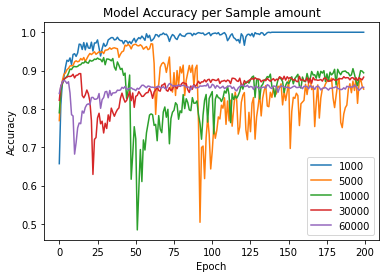

<Figure size 432x432 with 0 Axes>

In [14]:
# plt.plot(train_history.history['loss'])
plt.plot(sample_size_train_history[0][1])
plt.plot(sample_size_train_history[1][1])
plt.plot(sample_size_train_history[2][1])
plt.plot(sample_size_train_history[3][1])
plt.plot(sample_size_train_history[4][1])
# plt.plot(error_rate_train_history[5][1])
plt.title('Model Accuracy per Sample amount')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([
            f'1000',
            f'5000',
            f'10000',
            f'30000',
            f'60000'
            ])
plt.figure(figsize=(6, 6))
plt.show()

In [29]:
len(error_rate_train_history[0][0])

50

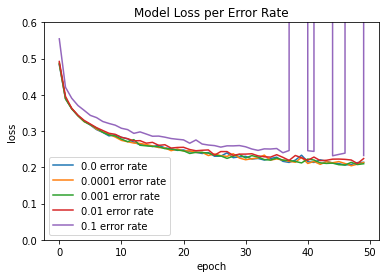

<Figure size 432x432 with 0 Axes>

In [49]:
# plt.plot(train_history.history['loss'])
plt.plot(error_rate_train_history[0][0])
plt.plot(error_rate_train_history[1][0])
plt.plot(error_rate_train_history[2][0])
plt.plot(error_rate_train_history[3][0])
plt.plot(error_rate_train_history[4][0])
# plt.plot(error_rate_train_history[5][1])
plt.title('Model Loss per Error Rate')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(top=0.6, bottom=0)
plt.legend([
            f'0.0 error rate',
            f'0.0001 error rate',
            f'0.001 error rate',
            f'0.01 error rate',
            f'0.1 error rate',
            f'0.5 error rate'
            ])
plt.figure(figsize=(6, 6))
# plt.show()
plt.savefig('figures/error_model_loss', bbox_inches='tight')